# How to use NeuralNetModel class
Just a simple notebook to show how easy is to use my NeuralNetModel class.

In few lines of code you can:
- Build a neural network
- Train it (sklearn like)
- Fine tune it freezing some layers

The class is built in such a way that all these operations can be done in a **single line of code**.

In [23]:
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import torch

# Fix numpy and torch seed
np.random.seed(42)
torch.manual_seed(42)

from ml.neuralnet import NeuralNetModel
from ml.neuralnet.utils.visualisation import plot_weights
from torch.nn import ReLU, Identity

## The dataset (borign part)
For this example I will build a simple dataset. We will focus on a non linear regression problem.

Two datasets will be built:
- The first one will be used to train the neural network
- The second one will be used to fine tune the neural network. Namely the first layers will be frozen and only the last layers will be updated on the new data. 

Both dataset will consist in a target and a single feature (let's keep it simple).


In [24]:
# Build data
N_train = 1000
X = np.linspace(0, 10, N_train).reshape(-1, 1)
y = 1 * X * np.sin(X) + 1.1*np.random.normal(0, 2, N_train).reshape(-1, 1)

N_finetune = 100
X_finetune = np.linspace(0, 10, N_finetune).reshape(-1, 1)
y_finetune = 1 * X_finetune * np.cos(X_finetune) + 0.3*np.random.normal(0, 2, N_finetune).reshape(-1, 1)


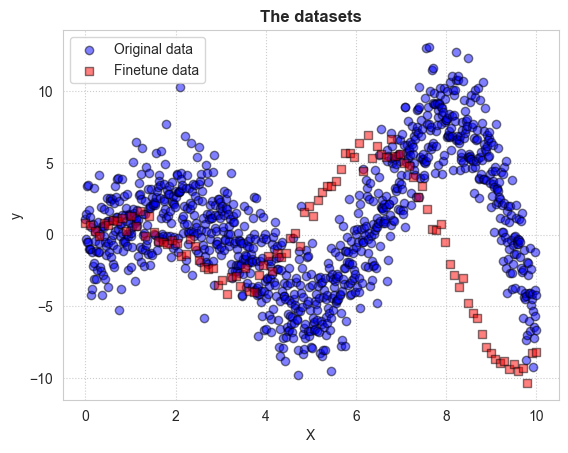

In [25]:
# Visualize data
plt.scatter(X, y, alpha=0.5, color='blue', edgecolors='black', label='Original data')
plt.scatter(X_finetune, y_finetune, alpha=0.5, color='red', edgecolors='black', label='Finetune data', marker='s')
plt.xlabel('X')
plt.ylabel('y')
plt.grid(linestyle=':')
plt.title('The datasets', fontweight='bold')
plt.legend()

## Build the neural network (interesting part!)
The neural network is built using the NeuralNetModel class.

Using this class you can build only full connected sequential models.

With the inputs `layers_units`, `activations`, `dropout_layers` you can define the architecture of the neural network.
With the remaining parameters: `epochs`, `batch_size`, `learning_rate`, `optimizer`  you can define the training procedure.

Keep in mind that you can update `epochs`, `batch_size` parameters also when calling the `fit` method.


In [35]:
# Build model
LAYER_UNITS = [10, 10, 10, 1]
HIDDEN_ACTIVATION = [ReLU(), ReLU(), ReLU(), Identity()]

neuralnet = NeuralNetModel(layers_units=LAYER_UNITS,
                           activations=HIDDEN_ACTIVATION,
                           dropout_layers=None,
                           epochs=800, batch_size=1000,
                           learning_rate=0.01, optimizer='Adam',
                           loss='mae',
                           verbose=False)

In [ ]:
# Train model
neuralnet.fit(X, y, shuffle=True)
pred = neuralnet.predict(X)

named_parameters_train = deepcopy(list(neuralnet.mlp.named_parameters()))
loss_history_fit = neuralnet.loss_history

## Fine tune the neural network in one line! (another interesting part!)
Once you have trained the neural network you can fine tune it on new data.

You can use `fine_tune` method to do so. With the parameter `freeze_layer_index` you can specify which layers you want to freeze in term of layer index (namely **which layers will not be updated**).

After `fine_tune` method is called alle the layers are unfreezed.


In [28]:
# Fine tune on new data
neuralnet.fine_tune(X=X_finetune, y=y_finetune, freeze_layer_index=[0, 1], epochs=600, shuffle=True)
pred_finetune = neuralnet.predict(X_finetune)

named_parameters_finetune = deepcopy(list(neuralnet.mlp.named_parameters()))
loss_history_finetune = neuralnet.loss_history

## Let's see the results (plots are always interesting)
We can look at the regression results toghether with the loss history of the two training procedures.

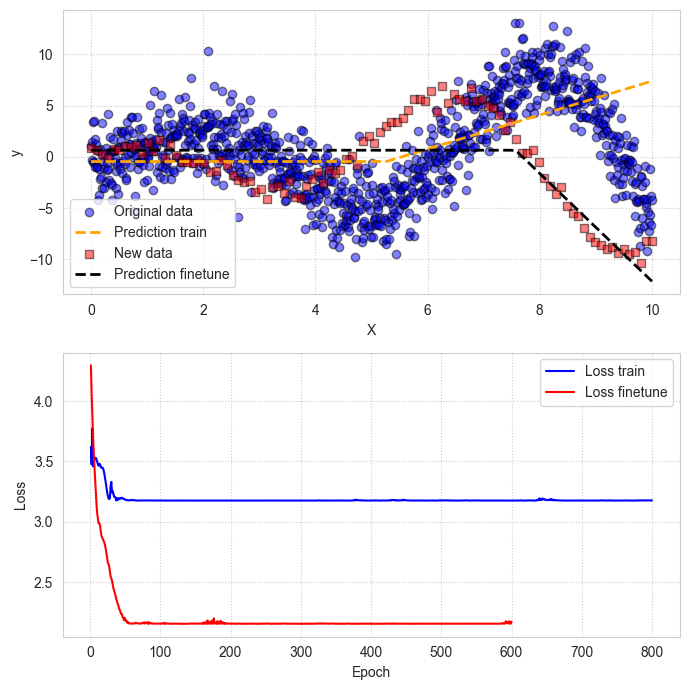

In [29]:
# Visualize results
fig, ax = plt.subplots(2, 1, figsize = (7, 7))

ax[0].scatter(X, y, alpha=0.5, color='blue', edgecolors='black', label='Original data')
ax[0].plot(X, pred, alpha=1, color='orange', linestyle='--', linewidth=2, label='Prediction train')
ax[0].scatter(X_finetune, y_finetune, alpha=0.5, color='red', edgecolors='black', label='New data', marker='s')
ax[0].plot(X_finetune, pred_finetune, alpha=1, color='black', linestyle='--', linewidth=2, label='Prediction finetune')
ax[0].set_xlabel('X')
ax[0].set_ylabel('y')
ax[0].grid(linestyle=':')
ax[0].legend()

ax[1].plot(loss_history_fit.index, loss_history_fit, label='Loss train', color='blue')
ax[1].plot(loss_history_finetune.index, loss_history_finetune, label='Loss finetune', color='red')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()
plt.show()

## Did the fine tuning work?
But how the weights changed after the fine tuning?
Let's see it.

### First two layers: these should be the same before and after fine tuning

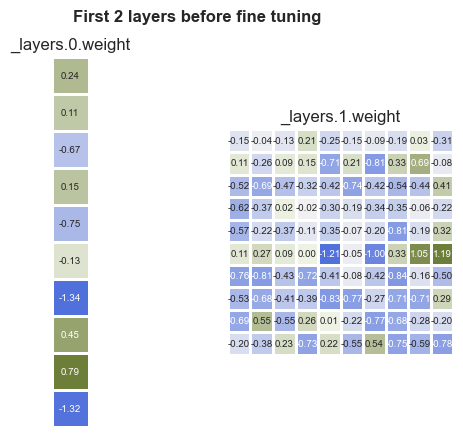

In [30]:
train_weights_parameters = [(name, param) for name, param in named_parameters_train if 'weight' in name.lower()]
plot_weights(train_weights_parameters[:2], annot=True, annot_kws={'size': 7}, subplot_title=True, title='First 2 layers before fine tuning')

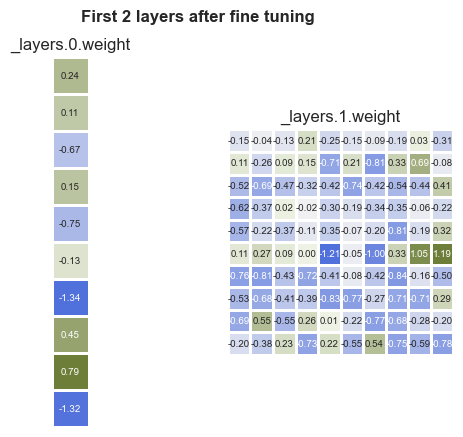

In [31]:
finetune_weights_parameters = [(name, param) for name, param in named_parameters_finetune if 'weight' in name.lower()]
plot_weights(finetune_weights_parameters[:2], annot=True, annot_kws={'size': 7}, subplot_title=True, title='First 2 layers after fine tuning')

### Last two layers: these should be different before and after fine tuning

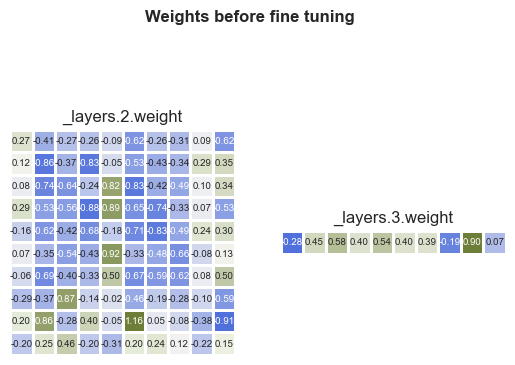

In [32]:
train_weights_parameters = [(name, param) for name, param in named_parameters_train if 'weight' in name.lower()]
plot_weights(train_weights_parameters[-2:], annot=True, annot_kws={'size': 7}, subplot_title=True, title='Weights before fine tuning')

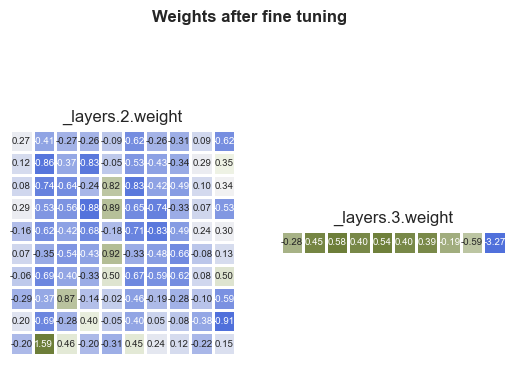

In [33]:
finetune_weights_parameters = [(name, param) for name, param in named_parameters_finetune if 'weight' in name.lower()]
plot_weights(finetune_weights_parameters[-2:], annot=True, annot_kws={'size': 7}, subplot_title=True, title='Weights after fine tuning')